# 🖼️ Image Metadata Analysis
  
You can:
- **Upload images** (JPG/PNG/TIFF/BMP/WEBP)
- **Extract metadata** (EXIF with camera model, timestamp, and GPS if present)
- **Run OCR** to read text in the image
- **Detect the language** of the extracted text
- **See per-image results** with previews and a **summary table**


## 🔍 What each step does

1. **Setup**  
   - Installs required libraries: `Pillow`, `exifread`, `pytesseract`, `opencv-python`, `langdetect`, `matplotlib`  
   - Creates folders used by the notebook:  
     - `/content/image_metadata_data` → where your uploaded images live  
     - `/content/image_metadata_outputs` → where JSON/TXT files are written (for reference).  
       > We still save files for transparency, but this notebook emphasizes *displaying* results inline.

2. **Upload Images**  
   - Lets you choose images from your computer and stores them in `/content/image_metadata_data`.

3. **Helper Functions**  
   - `extract_exif_pillow` → Gets EXIF via Pillow (raw EXIF dictionary)  
   - `extract_exif_exifread` → Gets EXIF/metadata via ExifRead (human-readable tags)  
   - `extract_gps_latlon_exifread` → Parses GPS tags (if present) into `(lat, lon)` degrees  
   - `ocr_text` → Uses OpenCV + Tesseract to extract text  
   - `detect_language_safe` → Detects language of the OCR text (returns `"unknown"` if not enough text)

4. **Process & Display**  
   - Iterates over images in `/content/image_metadata_data`  
   - Extracts EXIF and OCR results  
   - **Displays** for each image: the image preview, a compact info panel (file name, GPS, OCR language, OCR characters), and a short **OCR text snippet**  
   - Pulls **key EXIF fields** (e.g., `DateTimeOriginal`, `Make`, `Model`, `Orientation`) where available  
   - At the end, shows a **summary table** for all images (file, GPS, language, OCR length)




In [22]:

# @title ① Setup (installs packages) — run this first
import sys, subprocess

def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

need = []
try:
    import PIL
except Exception:
    need.append("pillow")
try:
    import exifread
except Exception:
    need.append("exifread")
try:
    import pytesseract
except Exception:
    need.append("pytesseract")
try:
    import cv2
except Exception:
    need.append("opencv-python")
try:
    import langdetect
except Exception:
    need.append("langdetect")
try:
    import matplotlib
except Exception:
    need.append("matplotlib")
try:
    import pandas
except Exception:
    need.append("pandas")

if need:
    print("Installing:", need)
    pip_install(need)
else:
    print("All dependencies already installed.")

from pathlib import Path
ROOT = Path("/content")
DATA = ROOT / "image_metadata_data"
OUT = ROOT / "image_metadata_outputs"
(DATA).mkdir(parents=True, exist_ok=True)
(OUT / "metadata_json").mkdir(parents=True, exist_ok=True)
(OUT / "ocr_texts").mkdir(parents=True, exist_ok=True)

print("Data folder:", DATA)
print("Outputs folder:", OUT)
print("✅ Setup complete.")


All dependencies already installed.
Data folder: /content/image_metadata_data
Outputs folder: /content/image_metadata_outputs
✅ Setup complete.


In [16]:

# @title ② Upload Images (JPG/PNG/TIFF/BMP/WEBP)
from pathlib import Path

DATA = Path("/content/image_metadata_data")
DATA.mkdir(parents=True, exist_ok=True)

uploaded_names = []
try:
    from google.colab import files
    up = files.upload()  # choose multiple images
    for name, content in up.items():
        p = DATA / name
        with open(p, "wb") as f:
            f.write(content)
        uploaded_names.append(name)
    print("Uploaded:", uploaded_names)
except Exception as e:
    print("If not running in Colab, place files into:", DATA)
    print("Error:", e)

print("Current files in data:", [p.name for p in DATA.iterdir() if p.is_file()])


Uploaded: []
Current files in data: ['kaggle-logo-png_seeklogo-335156.png', 'Gemini_Generated_Image_oaagqroaagqroaag.png', 'Gemini_Generated_Image_sf5orusf5orusf5o.png']


In [17]:
# @title ②b Fetch ALL images from GitHub repo (robust + diagnostics)
import subprocess, shutil, sys, os
from pathlib import Path

DATA = Path("/content/image_metadata_data")
DATA.mkdir(parents=True, exist_ok=True)

repo_url  = "https://github.com/Madhav-000-s/image-metadata-showcase.git"
repo_path = Path("/content/image-metadata-showcase")

# ---- Clone (or refresh) the repo ----
if not repo_path.exists():
    print("Cloning repo…")
    subprocess.run(["git", "clone", "--depth", "1", repo_url, str(repo_path)], check=True)
else:
    print("Repo already exists; pulling latest…")
    subprocess.run(["git", "-C", str(repo_path), "pull", "--ff-only"], check=True)



images_dir=repo_path / "images"
print(f"\nUsing images dir: {images_dir.relative_to(repo_path)}")
print("Listing images dir:")
for p in sorted(images_dir.iterdir()):
    print("  -", p.name)

from PIL import Image

img_count = 0
errors = []
for src in images_dir.rglob("*"):
    if not src.is_file():
        continue
    # Try verifying it’s an image by opening with Pillow
    try:
        with Image.open(src) as im:
            im.verify()  # lightweight validation
        # If it’s valid, copy it over
        target = DATA / src.name
        shutil.copy2(src, target)
        img_count += 1
        print("Copied:", src.name)
    except Exception as e:
        # Not an image or unreadable — record and skip
        errors.append((src.name, str(e)))

print(f"\n✅ {img_count} images copied into {DATA}")
if errors:
    print("\nSome files were skipped (not images or unreadable):")
    for name, err in errors:
        print(f"  - {name}: {err}")

# Show what’s now in DATA
print("\nFiles now in data:", [p.name for p in DATA.iterdir() if p.is_file()])


Repo already exists; pulling latest…

Using images dir: images
Listing images dir:
  - Gemini_Generated_Image_oaagqroaagqroaag.png
  - Gemini_Generated_Image_sf5orusf5orusf5o.png
  - images.txt
  - kaggle-logo-png_seeklogo-335156.png
Copied: kaggle-logo-png_seeklogo-335156.png
Copied: Gemini_Generated_Image_oaagqroaagqroaag.png
Copied: Gemini_Generated_Image_sf5orusf5orusf5o.png

✅ 3 images copied into /content/image_metadata_data

Some files were skipped (not images or unreadable):
  - images.txt: cannot identify image file '/content/image-metadata-showcase/images/images.txt'

Files now in data: ['kaggle-logo-png_seeklogo-335156.png', 'Gemini_Generated_Image_oaagqroaagqroaag.png', 'Gemini_Generated_Image_sf5orusf5orusf5o.png']



# Helper Functions



Below we define small, focused functions. They are written to be **robust** and **transparent**:
- `extract_exif_pillow` returns a flat dict from Pillow’s raw EXIF mapping (keys like `EXIF_306` for timestamps).
- `extract_exif_exifread` returns a dict where keys are human-readable tags (e.g., `EXIF DateTimeOriginal`, `Image Model`).
- `extract_gps_latlon_exifread` pulls out GPS DMS (degrees/minutes/seconds) values and converts to **decimal degrees**.
- `ocr_text` uses OpenCV to grayscale the image (helps OCR) and Tesseract to extract text.
- `detect_language_safe` uses `langdetect`; it returns `"unknown"` if there isn’t enough text to detect.


In [18]:

from typing import Dict, Any, Optional, Tuple
from pathlib import Path
import json

# Metadata libs
from PIL import Image
import exifread

# OCR / Language libs
import cv2, pytesseract
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

def save_json(obj, path: str):
    """Save a JSON file with UTF-8 encoding (for transparency & reproducibility)."""
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def extract_exif_pillow(img_path: str) -> Dict[str, Any]:
    """
    Extract EXIF using Pillow (_getexif). Returns a flat dict with raw numeric tag IDs.
    Many images (e.g., screenshots) won't have EXIF; then this will be empty.
    """
    flat = {}
    try:
        img = Image.open(img_path)
        raw = img._getexif() or {}
        for k, v in raw.items():
            flat[f"EXIF_{k}"] = str(v)
    except Exception as e:
        flat["error_pillow"] = str(e)
    return flat

def extract_exif_exifread(img_path: str) -> Dict[str, Any]:
    """
    Extract human-readable EXIF/metadata tags using ExifRead.
    Keys often look like 'EXIF DateTimeOriginal', 'Image Make', etc.
    """
    try:
        with open(img_path, 'rb') as f:
            tags = exifread.process_file(f, details=False)
        return {str(tag): str(value) for tag, value in tags.items()}
    except Exception as e:
        return {"error_exifread": str(e)}

def _dms_to_deg(dms_vals, ref):
    """Convert degrees/minutes/seconds to decimal degrees. Applies N/E positive, S/W negative."""
    try:
        d = float(dms_vals[0].num) / float(dms_vals[0].den)
        m = float(dms_vals[1].num) / float(dms_vals[1].den)
        s = float(dms_vals[2].num) / float(dms_vals[2].den)
        deg = d + m/60.0 + s/3600.0
        if ref in ["S", "W"]:
            deg = -deg
        return deg
    except Exception:
        return None

def extract_gps_latlon_exifread(img_path: str) -> Optional[Tuple[float, float]]:
    """
    Parse GPS EXIF tags using ExifRead and return (lat, lon) in decimal degrees.
    Returns None if no GPS is embedded.
    """
    try:
        with open(img_path, 'rb') as f:
            tags = exifread.process_file(f, details=False)
        lat = tags.get('GPS GPSLatitude')
        lon = tags.get('GPS GPSLongitude')
        lat_ref = str(tags.get('GPS GPSLatitudeRef') or "")
        lon_ref = str(tags.get('GPS GPSLongitudeRef') or "")
        if lat and lon:
            lat_deg = _dms_to_deg(lat.values, lat_ref)
            lon_deg = _dms_to_deg(lon.values, lon_ref)
            if lat_deg is not None and lon_deg is not None:
                return (lat_deg, lon_deg)
    except Exception:
        pass
    return None

def ocr_text(img_path: str) -> str:
    """
    Perform OCR on the image:
      1. Read image with OpenCV
      2. Convert to grayscale (often improves OCR)
      3. Run Tesseract
    Returns the extracted text (stripped).
    """
    img = cv2.imread(img_path)
    if img is None:
        return ""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(gray)
    return text.strip()

def detect_language_safe(text: str) -> str:
    """
    Detect language of OCR text. If text is too short or ambiguous,
    return 'unknown' instead of raising an error.
    """
    if not text or not text.strip():
        return "unknown"
    try:
        return detect(text)
    except Exception:
        return "unknown"


## 📊 Process & Display — what you’ll see

For **each image**:
- A **preview** of the image
- A **compact info panel** with:
  - File name
  - GPS (if found)
  - OCR language
  - OCR character count
- A short **OCR text snippet** (first ~240 chars)
- Key **EXIF fields** if present (e.g., DateTimeOriginal, Make, Model, Orientation)

At the **end**, you’ll get a **summary table** for all images.


Found 3 images. Processing...



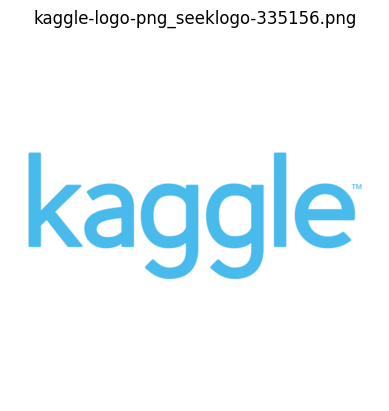

📄 File: kaggle-logo-png_seeklogo-335156.png
📌 GPS: None
🌐 OCR language: tl
🔤 OCR characters: 6
📝 OCR text snippet: 'kaggle'
🔎 Key EXIF fields: (none found)
------------------------------------------------------------------------------------------


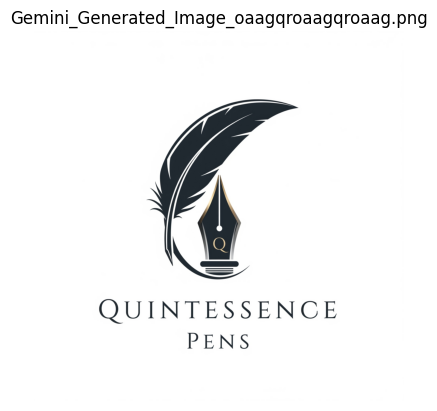

📄 File: Gemini_Generated_Image_oaagqroaagqroaag.png
📌 GPS: None
🌐 OCR language: vi
🔤 OCR characters: 17
📝 OCR text snippet: 'QUINTESSENCE\nPENS'
🔎 Key EXIF fields: (none found)
------------------------------------------------------------------------------------------


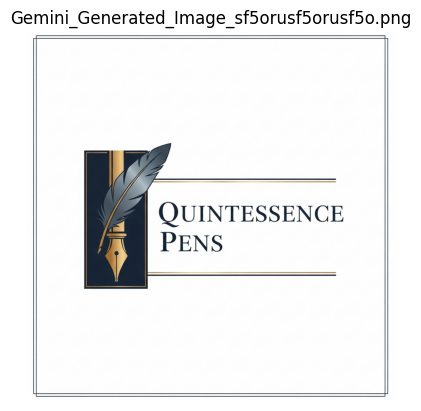

📄 File: Gemini_Generated_Image_sf5orusf5orusf5o.png
📌 GPS: None
🌐 OCR language: vi
🔤 OCR characters: 18
📝 OCR text snippet: 'QUINTESSENCE\n\nPENS'
🔎 Key EXIF fields: (none found)
------------------------------------------------------------------------------------------
✅ Summary table (all images):


,file,gps,ocr_lang,ocr_chars,EXIF DateTimeOriginal,Image Make,Image Model,EXIF LensModel,Image Orientation
0,kaggle-logo-png_seeklogo-335156.png,None,tl,6,,,,,
1,Gemini_Generated_Image_oaagqroaagqroaag.png,None,vi,17,,,,,
2,Gemini_Generated_Image_sf5orusf5orusf5o.png,None,vi,18,,,,,


In [24]:

# @title ④ Process & Display (inline results)
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import json

import logging
logging.getLogger("exifread").setLevel(logging.ERROR)


DATA = Path("/content/image_metadata_data")
OUT = Path("/content/image_metadata_outputs")
OUT_META = OUT / "metadata_json"
OUT_OCR = OUT / "ocr_texts"
OUT_META.mkdir(parents=True, exist_ok=True)
OUT_OCR.mkdir(parents=True, exist_ok=True)

# Collect images
img_paths = [p for p in DATA.iterdir() if p.suffix.lower() in [".jpg",".jpeg",".png",".tif",".tiff",".bmp",".webp"]]
if not img_paths:
    print("No images found. Please run 'Upload Images' and try again.")
else:
    print(f"Found {len(img_paths)} images. Processing...\n")

rows = []
key_fields = ["EXIF DateTimeOriginal", "Image Make", "Image Model", "EXIF LensModel", "Image Orientation"]

for p in img_paths:
    exif_p = extract_exif_pillow(str(p))
    exif_e = extract_exif_exifread(str(p))
    gps = extract_gps_latlon_exifread(str(p))
    text = ocr_text(str(p))
    lang = detect_language_safe(text)

    # Save reference artifacts (still helpful for auditing)
    save_json({"exif_pillow": exif_p, "exif_exifread": exif_e, "gps": gps}, str(OUT_META / f"{p.stem}.json"))
    (OUT_OCR / f"{p.stem}.txt").write_text(text or "", encoding="utf-8")

    # Prepare display-friendly data
    info = {
        "file": p.name,
        "gps": gps,
        "ocr_lang": lang,
        "ocr_chars": len(text),
    }
    for k in key_fields:
        info[k] = exif_e.get(k) or ""

    rows.append(info)

    # --- Display per image ---
    # Preview
    try:
        import matplotlib.image as mpimg
        img = mpimg.imread(str(p))
        plt.figure()
        plt.imshow(img)
        plt.axis('off')
        plt.title(p.name)
        plt.show()
    except Exception as e:
        print(f"(Preview skipped for {p.name}: {e})")

    # Compact panel
    print("📄 File:", p.name)
    print("📌 GPS:", gps if gps else "None")
    print("🌐 OCR language:", lang)
    print("🔤 OCR characters:", len(text))
    snippet = (text[:240] + "…") if len(text) > 240 else text
    print("📝 OCR text snippet:", repr(snippet))

    # Key EXIF fields
    if any(exif_e.get(k) for k in key_fields):
        print("🔎 Key EXIF fields (ExifRead):")
        for k in key_fields:
            if exif_e.get(k):
                print(f"   - {k}: {exif_e[k]}")
    else:
        print("🔎 Key EXIF fields: (none found)")
    print("-" * 90)

# --- Summary table (all images) ---
if rows:
    df = pd.DataFrame(rows)
    print("✅ Summary table (all images):")
    display(df)
